In [8]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# for results
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

pd.set_option("display.max_rows", 10)

In [49]:
# import DNN & initial setting

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


def compare_TV(history, train_met, val_met):
    acc = history.history[train_met]
    val_acc = history.history[val_met]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo' ,label = 'training '+train_met)
    plt.plot(epochs, val_acc, 'b' , label= 'validation '+val_met)
    plt.title('Training and Validation metrics')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

In [13]:
features_folder = '/content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Dataset/1_Processed/CSI_Features/2-seconds/'
features_list = [f for f in os.listdir(features_folder) if f.endswith('.csv')]

dfs_day1 = []
for file_name in features_list:
    # We will use data of day 1 and 2 for cross validation
    match = re.search(r"csi-features-full-d1-(\d)", file_name)
    if match:
      print(file_name)
      label = match.group(1)
      print("label:", label)
      file_path = os.path.join(features_folder, file_name)
      df = pd.read_csv(file_path)
      df["label"] = int(label)
      dfs_day1.append(df)

print("=========================")

dfs_day2 = []
for file_name in features_list:
    # We will use data of day 1 and 2 for cross validation
    match = re.search(r"csi-features-full-d2-(\d)", file_name)
    if match:
      print(file_name)
      label = match.group(1)
      print("label:", label)
      file_path = os.path.join(features_folder, file_name)
      df = pd.read_csv(file_path)
      df["label"] = int(label)
      dfs_day2.append(df)

print("Number of dataframes loaded for day 1: ", len(dfs_day1))

print("Number of dataframes loaded for day 2: ", len(dfs_day2))

csi-features-full-d1-0.csv
label: 0
csi-features-full-d1-1.csv
label: 1
csi-features-full-d1-2.csv
label: 2
csi-features-full-d1-3.csv
label: 3
csi-features-full-d1-4.csv
label: 4
csi-features-full-d1-5.csv
label: 5
csi-features-full-d2-0.csv
label: 0
csi-features-full-d2-1.csv
label: 1
csi-features-full-d2-2.csv
label: 2
csi-features-full-d2-3.csv
label: 3
csi-features-full-d2-4.csv
label: 4
csi-features-full-d2-5.csv
label: 5
Number of dataframes loaded for day 1:  6
Number of dataframes loaded for day 2:  6


In [14]:
for i in range(len(dfs_day1)):
    dfs_day1[i]['GT'] = i  # GT: ground truth

for i in range(len(dfs_day2)):
    dfs_day2[i]['GT'] = i  # GT: ground truth

In [15]:
df_day1_tot = pd.DataFrame()
df_day2_tot = pd.DataFrame()

for i in dfs_day1:
    df_day1_tot = pd.concat([df_day1_tot, i], axis = 0)

for i in dfs_day2:
    df_day2_tot = pd.concat([df_day2_tot, i], axis = 0)


In [16]:
df_day1_tot['session'] = 1
df_day2_tot['session'] = 2

In [18]:
df_tot = pd.DataFrame()

df_tot = pd.concat([df_tot,df_day1_tot], axis = 0)
df_tot = pd.concat([df_tot,df_day2_tot], axis = 0)

df_tot

,std_subcarrier_0,mean_subcarrier_0,max_subcarrier_0,min_subcarrier_0,qtu_subcarrier_0,qtl_subcarrier_0,iqr_subcarrier_0,std_subcarrier_1,mean_subcarrier_1,max_subcarrier_1,...,max_subcarrier_51,min_subcarrier_51,qtu_subcarrier_51,qtl_subcarrier_51,iqr_subcarrier_51,euc,rss_std,label,GT,session
0,2.458781,18.741377,23.436087,12.873449,20.788364,16.796083,3.992281,2.175019,18.433488,22.899534,...,24.661146,15.994982,20.205841,17.928362,2.277479,4.070442,1.086784,0,0,1
1,1.982891,20.387290,26.262447,14.678144,21.650830,19.327499,2.323331,1.839736,19.941909,24.315708,...,27.380480,15.994982,20.134831,18.125140,2.009691,4.369358,1.969365,0,0,1
2,2.532899,19.210716,24.707508,11.948169,21.059424,17.626041,3.433383,2.301174,18.658401,24.315708,...,27.380480,16.408403,23.155883,18.663023,4.492860,5.026204,2.295191,0,0,1
3,1.386501,17.874270,21.470917,14.713286,18.848673,16.946680,1.901993,1.583156,17.751923,21.570862,...,27.080818,15.729832,23.587442,21.055666,2.531776,5.124092,2.214221,0,0,1
4,1.468549,16.473418,20.004469,13.289907,17.542516,15.450712,2.091804,1.342521,16.696228,20.489609,...,26.816425,15.729832,21.224794,19.279030,1.945764,4.223744,1.898921,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,7.056776,34.804612,55.638992,15.810953,39.849208,30.384856,9.464352,7.033490,33.172505,56.187286,...,33.980125,3.055031,16.742629,8.327792,8.414837,11.275233,2.753017,5,5,2
212,6.468451,25.909284,38.385050,10.500432,31.191924,21.169424,10.022501,6.223530,24.755454,38.094635,...,23.984640,1.345444,14.972145,6.630679,8.341466,9.215453,2.369367,5,5,2
213,6.590707,26.442697,59.122128,12.179407,29.916318,22.516041,7.400277,5.683933,25.534375,48.478264,...,18.469904,1.345444,9.681362,6.234770,3.446592,7.406060,2.838481,5,5,2
214,8.346377,30.932321,54.297974,5.579738,35.622636,27.163545,8.459091,7.681499,28.999952,47.995940,...,33.519047,3.543178,19.549519,9.073132,10.476387,8.982358,3.455011,5,5,2


In [19]:
df_tot = df_tot.reset_index()
df_tot = df_tot.drop('index', axis = 1)

df_tot

,std_subcarrier_0,mean_subcarrier_0,max_subcarrier_0,min_subcarrier_0,qtu_subcarrier_0,qtl_subcarrier_0,iqr_subcarrier_0,std_subcarrier_1,mean_subcarrier_1,max_subcarrier_1,...,max_subcarrier_51,min_subcarrier_51,qtu_subcarrier_51,qtl_subcarrier_51,iqr_subcarrier_51,euc,rss_std,label,GT,session
0,2.458781,18.741377,23.436087,12.873449,20.788364,16.796083,3.992281,2.175019,18.433488,22.899534,...,24.661146,15.994982,20.205841,17.928362,2.277479,4.070442,1.086784,0,0,1
1,1.982891,20.387290,26.262447,14.678144,21.650830,19.327499,2.323331,1.839736,19.941909,24.315708,...,27.380480,15.994982,20.134831,18.125140,2.009691,4.369358,1.969365,0,0,1
2,2.532899,19.210716,24.707508,11.948169,21.059424,17.626041,3.433383,2.301174,18.658401,24.315708,...,27.380480,16.408403,23.155883,18.663023,4.492860,5.026204,2.295191,0,0,1
3,1.386501,17.874270,21.470917,14.713286,18.848673,16.946680,1.901993,1.583156,17.751923,21.570862,...,27.080818,15.729832,23.587442,21.055666,2.531776,5.124092,2.214221,0,0,1
4,1.468549,16.473418,20.004469,13.289907,17.542516,15.450712,2.091804,1.342521,16.696228,20.489609,...,26.816425,15.729832,21.224794,19.279030,1.945764,4.223744,1.898921,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609,7.056776,34.804612,55.638992,15.810953,39.849208,30.384856,9.464352,7.033490,33.172505,56.187286,...,33.980125,3.055031,16.742629,8.327792,8.414837,11.275233,2.753017,5,5,2
2610,6.468451,25.909284,38.385050,10.500432,31.191924,21.169424,10.022501,6.223530,24.755454,38.094635,...,23.984640,1.345444,14.972145,6.630679,8.341466,9.215453,2.369367,5,5,2
2611,6.590707,26.442697,59.122128,12.179407,29.916318,22.516041,7.400277,5.683933,25.534375,48.478264,...,18.469904,1.345444,9.681362,6.234770,3.446592,7.406060,2.838481,5,5,2
2612,8.346377,30.932321,54.297974,5.579738,35.622636,27.163545,8.459091,7.681499,28.999952,47.995940,...,33.519047,3.543178,19.549519,9.073132,10.476387,8.982358,3.455011,5,5,2


In [30]:
from sklearn.model_selection import LeaveOneGroupOut

sessions = df_tot['session']
y = df_tot['GT']

df_tot2 = df_tot.drop('session', axis = 1)
df_tot2 = df_tot2.drop('GT', axis = 1)

X = df_tot2.copy()
X

,std_subcarrier_0,mean_subcarrier_0,max_subcarrier_0,min_subcarrier_0,qtu_subcarrier_0,qtl_subcarrier_0,iqr_subcarrier_0,std_subcarrier_1,mean_subcarrier_1,max_subcarrier_1,...,std_subcarrier_51,mean_subcarrier_51,max_subcarrier_51,min_subcarrier_51,qtu_subcarrier_51,qtl_subcarrier_51,iqr_subcarrier_51,euc,rss_std,label
0,2.458781,18.741377,23.436087,12.873449,20.788364,16.796083,3.992281,2.175019,18.433488,22.899534,...,1.589243,19.110815,24.661146,15.994982,20.205841,17.928362,2.277479,4.070442,1.086784,0
1,1.982891,20.387290,26.262447,14.678144,21.650830,19.327499,2.323331,1.839736,19.941909,24.315708,...,1.791956,19.350528,27.380480,15.994982,20.134831,18.125140,2.009691,4.369358,1.969365,0
2,2.532899,19.210716,24.707508,11.948169,21.059424,17.626041,3.433383,2.301174,18.658401,24.315708,...,2.458377,20.993883,27.380480,16.408403,23.155883,18.663023,4.492860,5.026204,2.295191,0
3,1.386501,17.874270,21.470917,14.713286,18.848673,16.946680,1.901993,1.583156,17.751923,21.570862,...,1.944505,22.392527,27.080818,15.729832,23.587442,21.055666,2.531776,5.124092,2.214221,0
4,1.468549,16.473418,20.004469,13.289907,17.542516,15.450712,2.091804,1.342521,16.696228,20.489609,...,1.731372,20.439736,26.816425,15.729832,21.224794,19.279030,1.945764,4.223744,1.898921,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609,7.056776,34.804612,55.638992,15.810953,39.849208,30.384856,9.464352,7.033490,33.172505,56.187286,...,5.973345,12.534574,33.980125,3.055031,16.742629,8.327792,8.414837,11.275233,2.753017,5
2610,6.468451,25.909284,38.385050,10.500432,31.191924,21.169424,10.022501,6.223530,24.755454,38.094635,...,5.143326,10.681076,23.984640,1.345444,14.972145,6.630679,8.341466,9.215453,2.369367,5
2611,6.590707,26.442697,59.122128,12.179407,29.916318,22.516041,7.400277,5.683933,25.534375,48.478264,...,3.031798,8.111775,18.469904,1.345444,9.681362,6.234770,3.446592,7.406060,2.838481,5
2612,8.346377,30.932321,54.297974,5.579738,35.622636,27.163545,8.459091,7.681499,28.999952,47.995940,...,7.178396,14.688397,33.519047,3.543178,19.549519,9.073132,10.476387,8.982358,3.455011,5


In [31]:
X = X.values
y = y.values

In [32]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

In [33]:
logo = LeaveOneGroupOut()
logo.get_n_splits(X, y, groups = sessions)

2

In [24]:
# early stopping setting
early_stopping =  EarlyStopping(
                            monitor='val_mae',
                            min_delta=0,
                            patience=100,
                            verbose=1,
                            mode='auto')

Epoch 1/10000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.2239 - mae: 1.3321 - val_loss: 1.1798 - val_mae: 0.7449
Epoch 2/10000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2095 - mae: 0.8104 - val_loss: 0.6003 - val_mae: 0.5086
Epoch 3/10000
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6148 - mae: 0.5664 - val_loss: 0.3753 - val_mae: 0.4500
Epoch 4/10000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4770 - mae: 0.4863 - val_loss: 0.2568 - val_mae: 0.3464
Epoch 5/10000
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3974 - mae: 0.4497 - val_loss: 0.2364 - val_mae: 0.3279
Epoch 6/10000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3818 - mae: 0.4338 - val_loss: 0.2013 - val_mae: 0.3358
Epoch 7/10000
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.3456 - mae: 0.4177 - val_loss: 0.1616 - val_mae: 0.2839
Epoch 8/10000
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2446 - mae: 0.3518 - val_loss: 0.1909 - val_mae: 0.3191
Epoch 9/10000
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step 

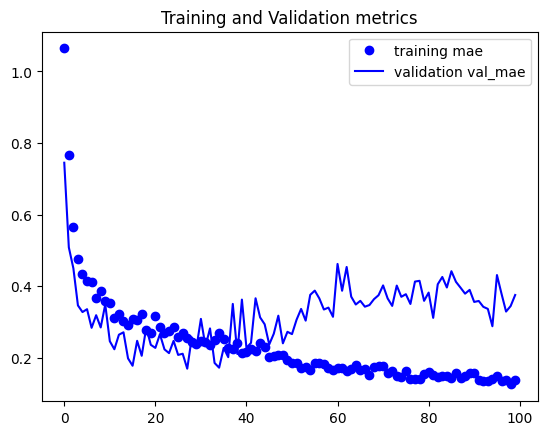

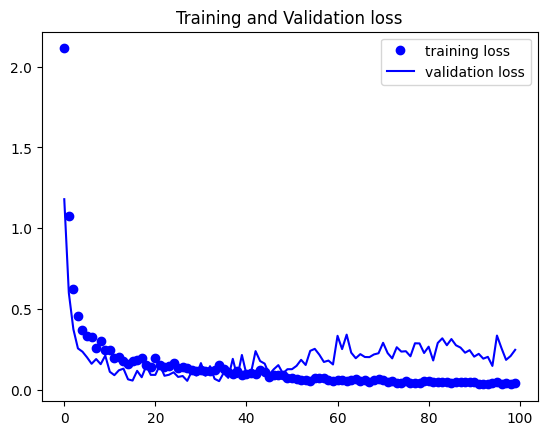

Epoch 1/10000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.3524 - mae: 1.5771 - val_loss: 1.3648 - val_mae: 0.8648
Epoch 2/10000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4818 - mae: 0.8820 - val_loss: 1.0773 - val_mae: 0.8097
Epoch 3/10000
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9837 - mae: 0.7266 - val_loss: 0.6399 - val_mae: 0.6025
Epoch 4/10000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7039 - mae: 0.6186 - val_loss: 0.6771 - val_mae: 0.5578
Epoch 5/10000
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6518 - mae: 0.5726 - val_loss: 0.5046 - val_mae: 0.5190
Epoch 6/10000
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5530 - mae: 0.5420 - val_loss: 0.4327 - val_mae: 0.4748
Epoch 7/10000
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4196 - mae: 0.4598 - val_loss: 0.2717 - val_mae: 0.3733
Epoch 8/10000
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.3067 - mae: 0.4036 - val_loss: 0.2306 - val_mae: 0.3480
Epoch 9/10000
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step 

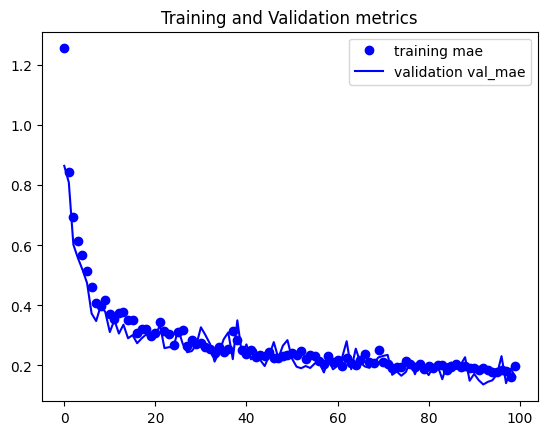

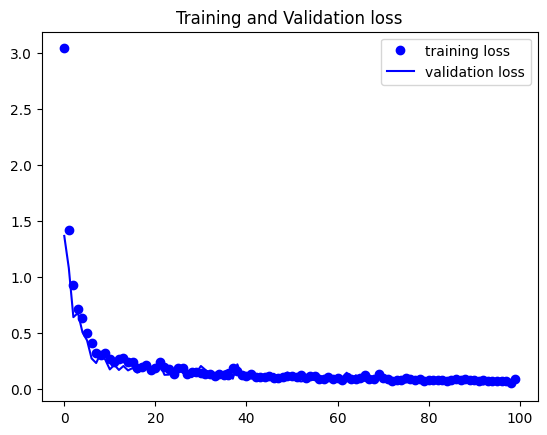

2024-10-31 07:45:31.501322


In [50]:
# learning

result_y_test=[]
result_y_pred=[]

count = 0

for train_index, test_index in logo.split(X, y, sessions):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=100, stratify=y_train)

    # Feature standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train=scaler.transform(X_train)
    X_val=scaler.transform(X_val)
    X_test=scaler.transform(X_test)

    model = Sequential()
    model.add(Dense(1000, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))

    opt = Adam(learning_rate=0.001)

    model.compile(optimizer=opt,
                  loss='mse',
                  metrics=['mae'])

    # fit
    history = model.fit(X_train, y_train,
                        batch_size=50,
                        epochs=10000,
                        verbose=1,
                        validation_data=(X_val, y_val),
                        callbacks=(early_stopping))

    # prediction
    y_pred = model.predict(X_test)

    # Append results
    result_y_test.extend(y_test)  # Use extend to flatten the list
    result_y_pred.extend(y_pred.flatten())  # Flatten y_pred before appending

    count += 1
    print(count)

    compare_TV(history, "mae", "val_mae")

print(datetime.datetime.now())

In [51]:
result_y_test = np.array(result_y_test)
result_y_pred = np.array(result_y_pred)

# Calculate and print metrics
print('DNN Regressor')
print('###########################')
print('Med-abs-err:', round(median_absolute_error(result_y_test, result_y_pred), 3))
print('Max-err:', round(max_error(result_y_test, result_y_pred), 4))
print('R2_score:', round(r2_score(result_y_test, result_y_pred), 4))

DNN Regressor
###########################
Med-abs-err: 0.644
Max-err: 3.8127
R2_score: 0.6399
